In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math


In [2]:
dataset = 0                 # If dataset 1 -> 0 dataset 2 -> 1
df = pd.read_csv("Dataset_1_Team_44.csv")
# df.rename(columns={"# x_1": "x1", "x_2": "x2", "Class_label" : "label"})
train_size = int(0.8 * df.shape[0])
test_size = int(0.2 * df.shape[0])
train_input = df[[]]
print("Train size : ", train_size)
print("Test size : " ,test_size)
train_input = df[['# x_1', 'x_2']].head(train_size)
train_output = df[['Class_label']].head(train_size)
test_input = df[['# x_1', 'x_2']].tail(test_size)
test_output = df[['Class_label']].tail(test_size)
train_output.shape



Train size :  3600
Test size :  900


(3600, 1)

In [0]:
#  convertng to np arrays
train_input = train_input.to_numpy()
train_output = train_output.to_numpy()
test_input = test_input.to_numpy()
test_output = test_output.to_numpy()

In [0]:
# function  Separating data into classes
def dataToClasses(input , output, size):
  class0 = []
  class1 = []
  class2 = []
  class_count = [0, 0, 0]

  for i in range(size):
    if output[i] == 0 :
      class0.append(input[i,:])
    elif output[i] == 1 :
      class1.append(input[i,:])
    elif output[i] == 2 :
      class2.append(input[i,:])
    class_count[output[i][0]] = class_count[output[i][0]] +1
  return class_count, np.array(class0).reshape(class_count[0],2), np.array(class1).reshape(class_count[1],2), np.array(class2).reshape(class_count[2],2)

In [0]:
# Segregating

train_count, train_class0, train_class1, train_class2 = dataToClasses(train_input, train_output, train_size)
test_count, test_class0, test_class1, test_class2 = dataToClasses(test_input, test_output, test_size)

In [6]:
train_priors = train_count / np.sum(train_count)
test_priors = test_count / np.sum(test_count)
print("train_priors : ", train_priors )
print("test_priors : ", test_priors )

train_priors :  [0.3325     0.33583333 0.33166667]
test_priors :  [0.33111111 0.32555556 0.34333333]


In [0]:
# calcuating covariance
def class_cov(class0, class1, class2):
  return [np.cov(class0, rowvar=False), np.cov(class1, rowvar=False), np.cov(class2, rowvar=False)]

In [8]:
train_class_cov = class_cov(train_class0, train_class1, train_class2)
train_class_cov

[array([[   83.6900167 ,   316.7898271 ],
        [  316.7898271 , 10027.29324628]]),
 array([[   60.39237238,   792.85816167],
        [  792.85816167, 24660.71451895]]),
 array([[  144.35390411,   -50.24812226],
        [  -50.24812226, 14367.15413232]])]

In [0]:
# calculating class mean
def class_mean(class0, class1, class2):
  return [[np.mean(class0[:,0]),np.mean(class0[:,1])],[np.mean(class1[:,0]),np.mean(class1[:,1])],[np.mean(class2[:,0]),np.mean(class2[:,1])]]

In [10]:
train_class_mean = class_mean(train_class0, train_class1, train_class2)
train_class_mean = np.array(train_class_mean)
train_class_mean

array([[  38.31453791, -580.42551198],
       [  38.3693151 ,   84.61958696],
       [ -17.15414503, -579.50850557]])

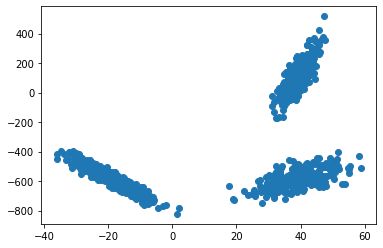

In [11]:
plt.scatter(test_input[:,0], test_input[:,1])

In [0]:
# class conditional densities
def ccd(input , mean , cov):
  cov_inv = np.linalg.inv(cov)
  cov_det = np.sqrt(np.linalg.det(cov))
  a = 1/((2*math.pi)*cov_det)
  u = np.dot( np.dot((input - mean), cov_inv) , (input - mean).T)     #Constants are class independent
  return a*np.exp(-u/2)

In [0]:
# calculating discrimant function
def discriminant_fun_same_cov(input,size,cov):
  labels = []
  for j in range(size):
    g0, g1, g2 = 0, 0, 0
    for i in range(3):
      g0 = g0 + L[0][i]*ccd(input[j,:],train_class_mean[i], cov)
      g1 = g1 + L[1][i]*ccd(input[j,:],train_class_mean[i], cov)
      g2 = g2 + L[2][i]*ccd(input[j,:],train_class_mean[i], cov)
    if(g0 <= g1 and g0 <=g2 ):
      labels.append(0)
    elif(g1 <= g0 and g1 <=g2 ):
      labels.append(1)
    elif(g2 <= g0 and g2 <=g1):
      labels.append(2)
  return labels


In [0]:
# calculating discrimant function for diff cov
def discriminant_fun_diff_cov(input, size, cov1, cov2, cov3):
  labels = []
  for j in range(size):
    g0, g1, g2 = 0, 0, 0
    a = ccd(input[j,:],train_class_mean[0], cov1)
    b = ccd(input[j,:],train_class_mean[1], cov2)
    c = ccd(input[j,:],train_class_mean[2], cov3)
    g0 = L[0][0]*a + L[0][1]*b + L[0][2]*c 
    g1 = L[1][0]*a + L[1][1]*b + L[1][2]*c
    g2 = L[2][0]*a + L[2][1]*b + L[2][2]*c
    if(g0 <= g1 and g0 <=g2 ):
      labels.append(0)
    elif(g1 <= g0 and g1 <=g2 ):
      labels.append(1)
    elif(g2 <= g0 and g2 <=g1):
      labels.append(2)
  return labels


In [0]:
def calAccuracy(labels, output, size):
  count = 0
  for i in range(size):
    if (labels[i] == output[i]):
      count = count+1
  return count/size

In [0]:
# Loss function 
  L = [[0, 2, 1], [2, 0, 3], [1, 2, 0]]



# Covarinace matrices
# if dataset == 1:
  # Naive bayes
  M1_cov = np.identity(2)
  M2_cov = np.diag([2000,1500])
  M3_cov1 = np.diag([10000,1500])
  M3_cov2 = np.diag([3000, 1800]) 
  M3_cov3 =np.diag([3500, 900])

  # Bayes
  M4_cov = np.array([[5000, 1800 ], [1800,1500]])
  M5_cov0 = np.array(train_class_cov[0])
  M5_cov1 = np.array(train_class_cov[1])
  M5_cov2 = np.array(train_class_cov[2])

# elif dataset == 0:
#   M1_cov = np.identity(2)
#   M2_cov = np.diag([350,15000])
#   M3_cov1 = np.diag([85,10000])
#   M3_cov2 = np.diag([60, 24600]) 
#   M3_cov3 =np.diag([145, 14300])

#   # Bayes
#   M4_cov = np.array([[350, 300 ], [300,15000]])
#   M5_cov0 = np.array(train_class_cov[0])
#   M5_cov1 = np.array(train_class_cov[1])
#   M5_cov2 = np.array(train_class_cov[2])




In [17]:
M5_cov2

array([[  144.35390411,   -50.24812226],
       [  -50.24812226, 14367.15413232]])

In [0]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

In [19]:
# Checcking Accuracy 
# Model 1
labels = discriminant_fun_same_cov(train_input, train_size, M1_cov)
print("Training accuracy for model 1 is : ", calAccuracy(labels, train_output, train_size))
print("Confusion matrix for model 1 train data is : \n", confusion_matrix(train_output, labels))

test_labels = discriminant_fun_same_cov(test_input, test_size, M1_cov)
print("Test accuracy for model 1 is : ", calAccuracy(test_labels, test_output, test_size))
print("Confusion matrix for model 1 test data is : \n", confusion_matrix(test_output, test_labels))



Training accuracy for model 1 is :  0.5255555555555556
Confusion matrix for model 1 train data is : 
 [[1189    5    3]
 [ 893  308    8]
 [ 791    8  395]]
Test accuracy for model 1 is :  0.5044444444444445
Confusion matrix for model 1 test data is : 
 [[296   1   1]
 [219  71   3]
 [220   2  87]]


In [20]:
# Checcking Accuracy 
# Model 2
labels = discriminant_fun_same_cov(train_input, train_size, M2_cov)
print("Training accuracy for model 2 is : ", calAccuracy(labels, train_output, train_size))
print("Confusion matrix for model 2 train data is : \n", confusion_matrix(train_output, labels))

test_labels = discriminant_fun_same_cov(test_input, test_size, M2_cov)
print("Test accuracy for model 2 is : ", calAccuracy(test_labels, test_output, test_size))
print("Confusion matrix for model 2 test data is : \n", confusion_matrix(test_output, test_labels))


Training accuracy for model 2 is :  0.9730555555555556
Confusion matrix for model 2 train data is : 
 [[1171   13   13]
 [  20 1173   16]
 [  16   19 1159]]
Test accuracy for model 2 is :  0.9722222222222222
Confusion matrix for model 2 test data is : 
 [[290   5   3]
 [  3 284   6]
 [  3   5 301]]


In [21]:
# Checcking Accuracy 
# Model 3
labels = discriminant_fun_diff_cov(train_input, train_size, M3_cov1, M3_cov2, M3_cov3)
print("Training accuracy for model 3 is : ", calAccuracy(labels, train_output, train_size))
print("Confusion matrix for model 3 train data is : \n", confusion_matrix(train_output, labels))

test_labels = discriminant_fun_diff_cov(test_input, test_size, M3_cov1, M3_cov2, M3_cov3)
print("Test accuracy for model 3 is : ", calAccuracy(test_labels, test_output, test_size))
print("Confusion matrix for model 3 test data is : \n", confusion_matrix(test_output, test_labels))


Training accuracy for model 3 is :  0.6888888888888889
Confusion matrix for model 3 train data is : 
 [[ 672   13  512]
 [  21 1173   15]
 [ 539   20  635]]
Test accuracy for model 3 is :  0.6711111111111111
Confusion matrix for model 3 test data is : 
 [[162   5 131]
 [  4 284   5]
 [146   5 158]]


In [22]:
# Checcking Accuracy 
# Model 4
labels = discriminant_fun_same_cov(train_input, train_size, M4_cov)
print("Training accuracy for model 4 is : ", calAccuracy(labels, train_output, train_size))
print("Confusion matrix for model 4 train data is : \n", confusion_matrix(train_output, labels))

test_labels = discriminant_fun_same_cov(test_input, test_size, M4_cov)
print("Test accuracy for model 4 is : ", calAccuracy(test_labels, test_output, test_size))
print("Confusion matrix for model 4 test data is : \n", confusion_matrix(test_output, test_labels))


Training accuracy for model 4 is :  0.7375
Confusion matrix for model 4 train data is : 
 [[ 823   13  361]
 [  19 1173   17]
 [ 515   20  659]]
Test accuracy for model 4 is :  0.7266666666666667
Confusion matrix for model 4 test data is : 
 [[204   5  89]
 [  4 284   5]
 [138   5 166]]


In [23]:
# Checcking Accuracy 
# Model 5
labels = discriminant_fun_diff_cov(train_input, train_size, M5_cov0, M5_cov1, M5_cov2)
print("Training accuracy for model 5 is : ", calAccuracy(labels, train_output, train_size))
print("Confusion matrix for model 5 train data is : \n", confusion_matrix(train_output, labels))

test_labels = discriminant_fun_diff_cov(test_input, test_size, M5_cov0, M5_cov1, M5_cov2)
print("Test accuracy for model 5 is : ", calAccuracy(test_labels, test_output, test_size))
print("Confusion matrix for model 5 test data is : \n", confusion_matrix(test_output, test_labels))


Training accuracy for model 5 is :  0.9733333333333334
Confusion matrix for model 5 train data is : 
 [[1170   13   14]
 [  19 1174   16]
 [  15   19 1160]]
Test accuracy for model 5 is :  0.9722222222222222
Confusion matrix for model 5 test data is : 
 [[290   5   3]
 [  3 284   6]
 [  3   5 301]]


In [24]:
M5_cov2

array([[  144.35390411,   -50.24812226],
       [  -50.24812226, 14367.15413232]])

Text(0.5, 1.0, 'Decision boundary')

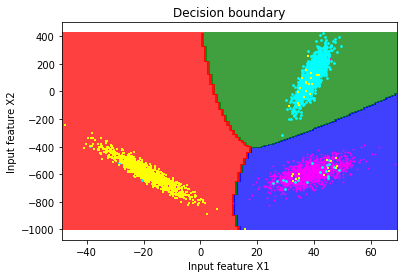

In [25]:
ds_size = [169337, 220110]
from matplotlib.colors import ListedColormap
X_set, y_set = train_input, train_output
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 1),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 1))
plt.contourf(X1, X2, np.array(discriminant_fun_diff_cov(np.array([X1.ravel(), X2.ravel()]).T, ds_size[dataset], M5_cov0, M5_cov1, M5_cov2)).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('blue', 'green','Red')))
plt.scatter(train_class0[:,0], train_class0[:,1], marker = '.', s =3, c = 'magenta' )
plt.scatter(train_class1[:,0], train_class1[:,1], marker = 'o', s =3, c = 'cyan' )
plt.scatter(train_class2[:,0], train_class2[:,1], marker = '+', s =3, c = 'yellow' )
plt.xlabel("Input feature X1")
plt.ylabel("Input feature X2")
plt.title("Decision boundary")

In [26]:
330 * 667

220110

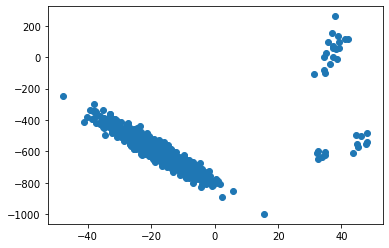

In [27]:
plt.scatter(train_class2[:,0],train_class2[:,1])

In [0]:
# class conditional densities
def pdf(input , mean , cov):
  pdfs = []
  for i in range(input.shape[0]):
    cov_inv = np.linalg.inv(cov)
    cov_det = np.sqrt(np.linalg.det(cov))
    a = 1/((2*math.pi)*cov_det)
    u = np.dot( np.dot((input[i,:] - mean), cov_inv) , (input[i, :] - mean).T)     #Constants are class independent
    pdfs.append(a*np.exp(-u/2))
  return pdfs

Text(0.5, 1.0, 'constant density curves and eigen vectors')

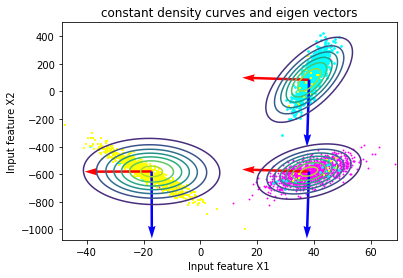

In [29]:
# pdfs and eigen vectors
plt.contour(X1, X2, np.array(pdf( np.array([X1.ravel(), X2.ravel()]).T, train_class_mean[0], M5_cov0 )).reshape(X1.shape),)
plt.contour(X1, X2, np.array(pdf( np.array([X1.ravel(), X2.ravel()]).T, train_class_mean[1], M5_cov1 )).reshape(X1.shape),)
plt.contour(X1, X2, np.array(pdf( np.array([X1.ravel(), X2.ravel()]).T, train_class_mean[2], M5_cov2 )).reshape(X1.shape),)
plt.scatter(train_class0[:,0], train_class0[:,1], marker = '.', s =3, c = 'magenta' )
plt.scatter(train_class1[:,0], train_class1[:,1], marker = 'o', s =3, c = 'cyan' )
plt.scatter(train_class2[:,0], train_class2[:,1], marker = '+', s =3, c = 'yellow' )

eigen_values1, eigen_vectors1 = np.linalg.eig(M5_cov0)
origin = train_class_mean[0]
eig_vec1 = eigen_vectors1[:,0]
eig_vec2 = eigen_vectors1[:,1]
plt.quiver(*origin, *eig_vec1, color=['r'], scale=5)
plt.quiver(*origin, *eig_vec2, color=['b'], scale=5)

eigen_values1_1, eigen_vectors1_1 = np.linalg.eig(M5_cov1)
origin = train_class_mean[1]
eig_vec1_1 = eigen_vectors1_1[:,0]
eig_vec2_1 = eigen_vectors1_1[:,1]
plt.quiver(*origin, *eig_vec1_1, color=['r'], scale=5)
plt.quiver(*origin, *eig_vec2_1, color=['b'], scale=5)

eigen_values1_2, eigen_vectors1_2 = np.linalg.eig(M5_cov2)
origin = train_class_mean[2]
eig_vec1_2 = eigen_vectors1_2[:,0]
eig_vec2_2 = eigen_vectors1_2[:,1]
plt.quiver(*origin, *eig_vec1_2, color=['r'], scale=5)
plt.quiver(*origin, *eig_vec2_2, color=['b'], scale=5)
plt.xlabel("Input feature X1")
plt.ylabel("Input feature X2")
plt.title("constant density curves and eigen vectors")

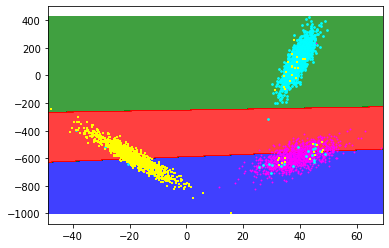

In [30]:
plt.contourf(X1, X2, np.array(discriminant_fun_same_cov(np.array([X1.ravel(), X2.ravel()]).T, ds_size[dataset], M4_cov)).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('blue', 'green','Red')))
plt.scatter(train_class0[:,0], train_class0[:,1], marker = '.', s =3, c = 'magenta' )
plt.scatter(train_class1[:,0], train_class1[:,1], marker = 'o', s =3, c = 'cyan' )
plt.scatter(train_class2[:,0], train_class2[:,1], marker = '+', s =3, c = 'yellow' )

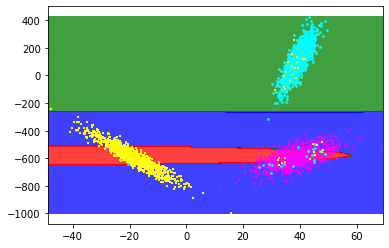

In [31]:
plt.contourf(X1, X2, np.array(discriminant_fun_diff_cov(np.array([X1.ravel(), X2.ravel()]).T, ds_size[dataset], M3_cov1, M3_cov2, M3_cov3)).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('blue', 'green','Red')))
plt.scatter(train_class0[:,0], train_class0[:,1], marker = '.', s =3, c = 'magenta' )
plt.scatter(train_class1[:,0], train_class1[:,1], marker = 'o', s =3, c = 'cyan' )
plt.scatter(train_class2[:,0], train_class2[:,1], marker = '+', s =3, c = 'yellow' )

In [32]:
X1.ravel().shape
# np.array([X1.ravel(), X2.ravel()]).shape

(169337,)